In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np
import re

In [2]:
from min_bisection import solution_schema

In [46]:
fldr = 'runs\\random_pp'

In [49]:
meta_dfs = []
run_dfs = []
sub_fldrs = [x[0] for x in os.walk(fldr)]
for sub_fldr in sub_fldrs[1:]:
    if 'profiles' in sub_fldr:
        continue
    print(sub_fldr)
    meta_dfs.append(pd.read_csv(os.path.join(sub_fldr, 'summary_stats.csv')))
    run_dfs.append(pd.read_csv(os.path.join(sub_fldr, 'run_stats.csv')))
meta = pd.concat(meta_dfs)
meta['threshold_proportion'] = meta['threshold_proportion'].fillna(0)
run = pd.concat(run_dfs)
run['threshold_proportion'] = run['threshold_proportion'].fillna(0)

runs\random_pp\random_pp_10
runs\random_pp\random_pp_100
runs\random_pp\random_pp_110
runs\random_pp\random_pp_120
runs\random_pp\random_pp_130
runs\random_pp\random_pp_140
runs\random_pp\random_pp_150
runs\random_pp\random_pp_20
runs\random_pp\random_pp_30
runs\random_pp\random_pp_40
runs\random_pp\random_pp_50
runs\random_pp\random_pp_60
runs\random_pp\random_pp_70
runs\random_pp\random_pp_80
runs\random_pp\random_pp_90


In [50]:
meta

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,once,auto,cold,1.0,0.0,10,0.5,0.1,fixed,1000,45,481,0.040375,0.006751,0.033624,3.000000
1,1,once,auto,cold,1.0,0.0,10,0.5,0.1,fixed,10000,45,481,0.031585,0.004068,0.027518,0.000000
2,2,once,auto,cold,1.0,0.0,10,0.5,0.1,fixed,100000,45,481,0.033834,0.006514,0.027320,1.428571
3,3,once,auto,cold,1.0,0.0,10,0.5,0.1,fixed,1000000,45,481,0.029398,0.003248,0.026149,2.000000
4,4,once,auto,cold,1.0,0.0,10,0.5,0.2,fixed,1000,45,481,0.033648,0.007664,0.025983,5.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,77,iterative,auto,warm,1.0,0.5,90,0.8,0.2,fixed,10000,4005,10273,7.665872,2.530075,5.135798,389.000000
236,77,iterative,auto,warm,1.0,0.9,90,0.8,0.2,fixed,10000,4005,19322,8.974369,2.668631,6.305737,389.000000
237,78,once,auto,cold,1.0,0.0,90,0.8,0.2,fixed,100000,4005,469921,320.548271,297.857814,22.690457,408.000000
238,78,iterative,auto,warm,1.0,0.5,90,0.8,0.2,fixed,100000,4005,47374,10.468521,3.672042,6.796479,408.000000


In [51]:
run

,solve_id,solve_type,method,warm_start,min_search_proportion,threshold_proportion,sub_solve_id,n,p,q,cut_type,cut_value,cuts_sought,cuts_added,search_proportion_used,current_threshold,variables,constraints,cpu_time
0,0,once,auto,cold,1.0,0.0,0,10,0.5,0.1,fixed,1000,480,480,1.0,NaN,45,481,0.006751
1,1,once,auto,cold,1.0,0.0,0,10,0.5,0.1,fixed,10000,480,480,1.0,NaN,45,481,0.004068
2,2,once,auto,cold,1.0,0.0,0,10,0.5,0.1,fixed,100000,480,480,1.0,NaN,45,481,0.006514
3,3,once,auto,cold,1.0,0.0,0,10,0.5,0.1,fixed,1000000,480,480,1.0,NaN,45,481,0.003248
4,4,once,auto,cold,1.0,0.0,0,10,0.5,0.2,fixed,1000,480,480,1.0,NaN,45,481,0.007664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,78,once,auto,cold,1.0,0.0,0,90,0.8,0.2,fixed,100000,469920,469920,1.0,NaN,4005,469921,297.857814
1006,78,iterative,auto,warm,1.0,0.5,0,90,0.8,0.2,fixed,100000,100,100,1.0,NaN,4005,101,0.010752
1007,78,iterative,auto,warm,1.0,0.5,1,90,0.8,0.2,fixed,100000,100000,46925,1.0,NaN,4005,47026,3.577629
1008,78,iterative,auto,warm,1.0,0.5,2,90,0.8,0.2,fixed,100000,100000,348,1.0,NaN,4005,47374,0.083661


In [60]:
def cpu_time_graph(time_measure, ignored_patterns, line_style):
    col_selection = time_measure if time_measure != 'proportion_cpu_time_gurobi' else ['total_cpu_time', 'gurobi_cpu_time']
    # average the runs
    gd = meta.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_search_proportion', 'threshold_proportion', 'n'])[col_selection].mean().reset_index()
    gd['idx'] = gd['solve_type'] + '_' + gd['cut_value'].astype(str) + '_' + gd['min_search_proportion'].astype(str) + '_' + gd['threshold_proportion'].astype(str)

    # filter graph data by data set
    filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

    # graph for each p, q combination 
    for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
        for name, fltr in filters.items():
            if any([ip in name for ip in ignored_patterns]):
                continue
            subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
            match = re.search('iterative_(.*)_.*_.*', name).group(1) if re.search('iterative_(.*)_.*_.*', name) else 'no_match'
            style = line_style.get(match, '-')
            if isinstance(col_selection, list):
                plt.plot(subset['n'], subset[col_selection[1]]/subset[col_selection[0]], linestyle=style, label=name)
                plt.ylabel('proportion_of_cpu_time')
            else:
                plt.plot(subset['n'], subset[col_selection], linestyle=style, label=name)
                plt.ylabel('cpu_time')

        plt.title(f'{time_measure} comparison for p={p}, q={q}')
        plt.xlabel('n')
        plt.legend()
        plt.show()

## Settings

In [61]:
# ignored_patterns = ['1000_',
#                     '10000_',
#                     '100000_',
#                     '1000000_']

ignored_patterns = []

line_style = {
    '10': ':',
    '100': '-.',
    '1000': '--',
    '10000': ':',
    '100000': '-.',
    '1000000': '--'
}

## Total CPU Time

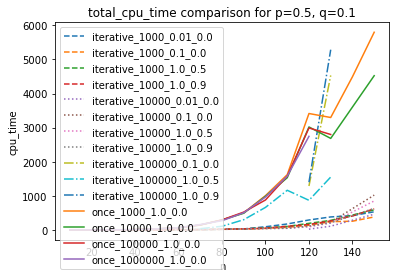

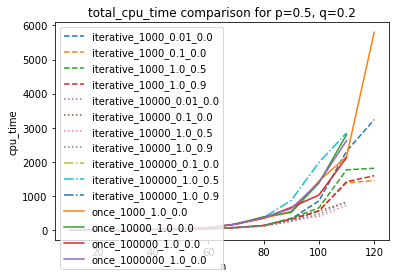

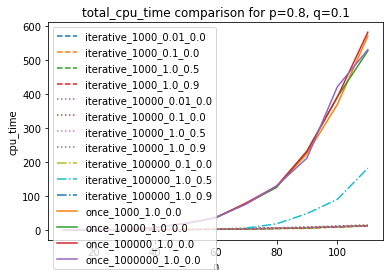

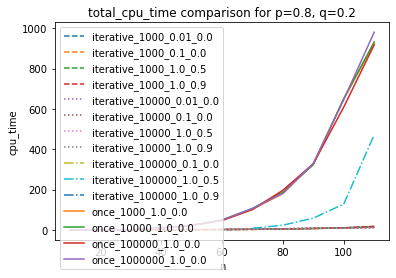

In [62]:
time_measure = 'total_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, line_style)

## Gurobi CPU Time

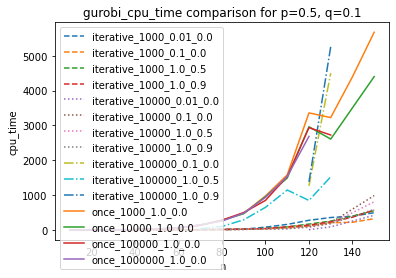

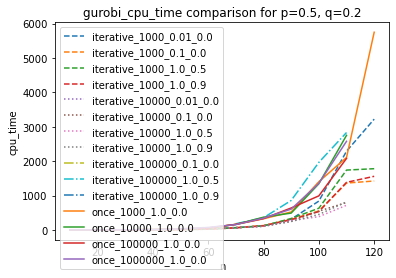

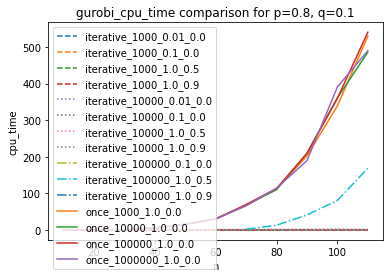

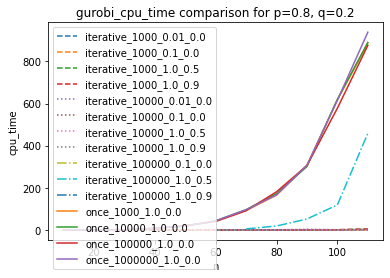

In [63]:
time_measure = 'gurobi_cpu_time'
cpu_time_graph(time_measure, ignored_patterns, line_style)

## Proportion CPU Time Gurobi

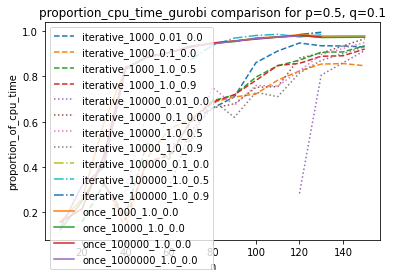

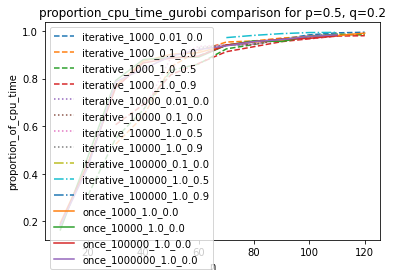

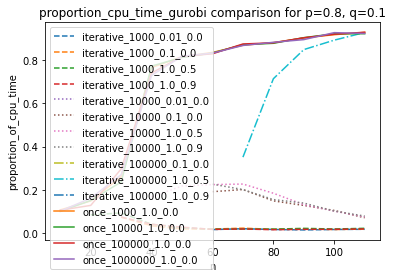

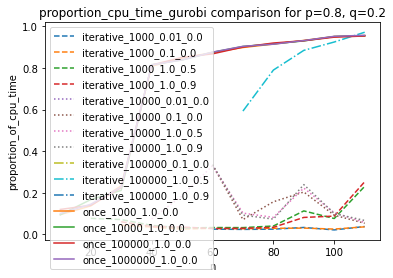

In [64]:
time_measure = 'proportion_cpu_time_gurobi'
cpu_time_graph(time_measure, ignored_patterns, line_style)

## Number of LP's per Solve

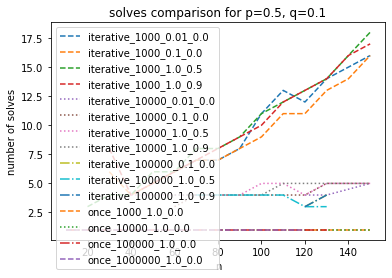

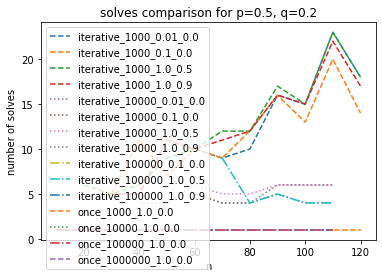

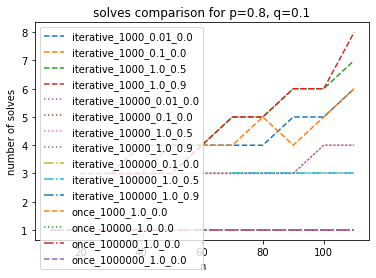

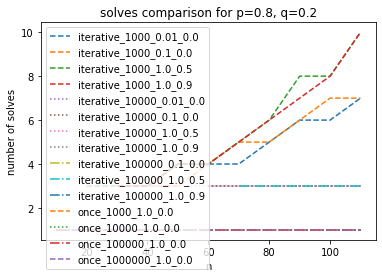

In [66]:
# count number of runs
gd = run.groupby(['p', 'q', 'solve_type', 'cut_value', 'min_search_proportion', 'threshold_proportion', 'n'])['sub_solve_id'].max().reset_index()

# create id
gd['idx'] = gd['solve_type'] + '_' + gd['cut_value'].astype(str) + '_' + gd['min_search_proportion'].astype(str) + '_' + gd['threshold_proportion'].astype(str)

# rename and adjust for 0 indexing
gd.rename(columns={'sub_solve_id': 'solves'}, inplace=True)
gd['solves'] += 1

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q) in product(gd['p'].unique(), gd['q'].unique()):
    for name, fltr in filters.items():
        if any([ip in name for ip in ignored_patterns]):
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & fltr].sort_values('n')
        style = line_style.get(re.search('\w+_(.*)_.*_.*', name).group(1), '-')
        plt.plot(subset['n'], subset['solves'], linestyle=style, label=name)

    plt.title(f'solves comparison for p={p}, q={q}')
    plt.ylabel('number of solves')
    plt.xlabel('n')
    plt.legend()
    plt.show()